# Problem 4.1

In [2]:
'''
Things to note:

- Now we are using the skorch library which allows us to do parameter tunning in the same way as for
other classifiers in sklearn. 
- The code to add L1 regularization is already implemented.

'''

'\nThings to note:\n\n- Now we are using the skorch library which allows us to do parameter tunning in the same way as for\nother classifiers in sklearn. \n- The code to add L1 regularization is already implemented.\n\n'

In [61]:
'''
Import packages 
'''

%matplotlib inline

from sklearn.datasets import fetch_openml # Import MNIST from a Package
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Standard PyTorch Imports
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
# We will be using the PyTorch Wrapper Framework skorch to help simplify the coding
from skorch import NeuralNetClassifier

# We need to import some Sci-kit Learn modules for computation purposes.
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from IPython.display import display
from skorch.callbacks import EarlyStopping

# Global Settings - These settings are critical

# If CUDA is available, use CUDA or else default to CPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting a seed for torch
torch.manual_seed(0)


In [4]:
'''
Import the data
'''
# select the root = ....

mnist = torchvision.datasets.MNIST(root = './data', 
                                   train = True, 
                                   transform = transforms.ToTensor(),  
                                   download = True)

test_dataset = torchvision.datasets.MNIST(root = './data', 
                                          train = False, 
                                          transform = transforms.ToTensor())


X_train = mnist.data
y_train = mnist.targets

X_test = test_dataset.data
y_test = test_dataset.targets

print(y_train[:5])


'''
Step -- Normalize each input from [0.0,1.0] range
'''
X_train = X_train/255.0
X_test = X_test/255.0


'''
Step -- Reshape X to have 4 dimension that is batch_size, channels, Height, Width
'''
display(X_train[:5].shape)
X_train = X_train.reshape(-1, 1, 28, 28)
X_test = X_test.reshape(-1, 1, 28, 28)
display(X_train[:5].shape)



tensor([5, 0, 4, 1, 9])


torch.Size([5, 28, 28])

torch.Size([5, 1, 28, 28])

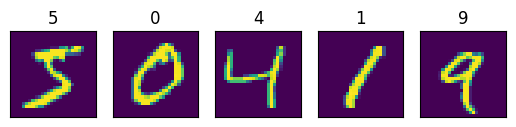

In [5]:

'''
Will do some basic plotting to get a feel for the data that we imported.

'''

def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y.item())
        
plot_example(X_train, y_train)

In [5]:
# build your CNN 
class CNN(nn.Module):
    def __init__(self, dropout = 0.4, number_of_nodes=200):
        super(CNN, self).__init__()
        '''Step -- Fill in the architecture'''
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
            nn.Flatten(),
        )    
        # fully connected layer, output 10 classes
        self.out = nn.Sequential(
                nn.Linear(32 * 7 * 7, number_of_nodes),
                nn.ReLU(),                      
                nn.Dropout(dropout),
                nn.Linear(number_of_nodes, 10),
                nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Step -- Fill in the Forward propagation function'''
        x = self.conv1(x)
        x = self.conv2(x)        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output


In [8]:
# Adding L1 regularization

class RegularizedNet(NeuralNetClassifier):
    
    ''''''
    
    def __init__(self, *args, lambda1 = 0.01, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_history_ = []
        self.lambda1 = lambda1
    
    ''' *** Explain -- What is the following method doing? Explain in detail in the main pdf ***'''
    
    def get_loss(self, y_pred, y_true, X = None, training = False):
        loss = super().get_loss(y_pred, y_true, X = X, training = training)
        loss += self.lambda1 * sum([w.abs().sum() for w in self.module_.parameters()])
        self.loss_history_.append(loss.item())
        return loss

In [17]:
# print out the structure of the model 
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Flatten(start_dim=1, end_dim=-1)
  )
  (out): Sequential(
    (0): Linear(in_features=1568, out_features=200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=200, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)


In [5]:
'''
Check Device == 'cuda'. USE GPU !!!!. Otherwise things will be super slow. Check
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d 
'''

print('Using Device = ',device)

Using Device =  cuda


In [6]:
'''
Here we define the RegularizedNet. Make sure you use nn.NLLLoss. Thus, you have to use a correct last activation
in the forward method of your network

We can specify different parameters such as learning rate (lr), our optimizar (start with standard SGD, in 4.3 we will
try another ones), batch size etc.
To define the arquitecture parameters for CNN write them as module__<name of your parameter> = ....

Since we have to train it first with L2 regularization lambda1 should be equal to 0
'''
cnn = RegularizedNet(module = CNN, 
                     max_epochs = 30, 
                     criterion = nn.NLLLoss,
                     optimizer = torch.optim.SGD, 
                     lr = .02, 
                     lambda1 = 0,
                     module__dropout = .2,
                     optimizer__weight_decay = 1e-3, 
                     device = device,
                     iterator_train__num_workers = 2,
                     iterator_train__pin_memory = True,
                     iterator_valid__num_workers = 2,
                     iterator_valid__pin_memory = True,
                     callbacks = [EarlyStopping(patience = 5, monitor = 'valid_acc', lower_is_better = False, threshold=.001)]
    )
    

In [7]:
'''Step - train the network'''

cnn.fit(X_train, y_train)
y_pred_probs = cnn.predict(X_test)

'''
Look how your loss is going down as well as the validation accuracy is increasing 
'''

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.3109       0.8656        0.4388  3.7693
      2        0.3433       0.9161        0.2669  2.1897
      3        0.2261       0.9377        0.2000  2.2137
      4        0.1742       0.9520        0.1555  2.2224
      5        0.1409       0.9593        0.1308  2.2178
      6        0.1214       0.9646        0.1150  2.2286
      7        0.1077       0.9680        0.1042  2.2137
      8        0.0960       0.9699        0.0962  2.2333
      9        0.0860       0.9718        0.0917  2.2364
     10        0.0819       0.9744        0.0831  2.2121
     11        0.0761       0.9768        0.0755  2.2724
     12        0.0718       0.9778        0.0757  2.2200
     13        0.0671       0.9787        0.0705  2.2503
     14        0.0634       0.9789        0.0697  2.2438
     15        0.0595       0.9807        0.0654  2.2451
     16        0.0581       0.9

'\nLook how your loss is going down as well as the validation accuracy is increasing \n'

In [ ]:
'''Step - Predict for the test set and print the final accuracy score, your validation accuracy obtained in the previous
cell should be similar to the accuracy in the test set
'''
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9883

In [ ]:
'''The idea is that you should get more than 98% of accuracy, so try different parameters as requested in the main pdf
The fit method is already showing you a validation error which can be used to compare between different parameters.

for the final submission leave the best parameters in your RegularizedNet(...)
'''
'''
Instead of doing it manually skorch allows us to use GridSearchCV from sklearn 
'''
from sklearn.model_selection import GridSearchCV

'''
Step - define a grid with some parameters that you consider may give you good results and 
the code will do the rest for you

* Especially take into account the parameters we are asking for to tune:  
Learning rate, regularization parameter, and the number of nodes

'''
# you can use cnn.get_params().keys() to get all the parameters that you can tune

grid = {
    'lr': [ .02, .025, .03,],
    'optimizer__weight_decay': [  1e-4, 5e-4, 1e-3,],
    'module__dropout': [ .2, .3,.4],
    'module__number_of_nodes': [ 300],
}

'''
Important that you keep refit = True
'''
gs = GridSearchCV(cnn, grid, refit = True, cv = 3, scoring = 'accuracy', n_jobs=1)


'''
Finally fit
'''
gs.fit(X_train, y_train)

#Report Best Parameters
print(gs.best_score_, gs.best_params_)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.6563       0.7910        0.6338  1.3735
      2        0.4411       0.8936        0.3358  1.3029
      3        0.2862       0.9135        0.2616  1.4594
      4        0.2193       0.9239        0.2256  1.4300
      5        0.1776       0.9415        0.1726  1.3900
      6        0.1490       0.9547        0.1430  1.4258
      7        0.1285       0.9564        0.1304  1.3833
      8        0.1137       0.9653        0.1112  1.3670
      9        0.1025       0.9656        0.1068  1.3132
     10        0.0937       0.9698        0.0956  1.2701
     11        0.0867       0.9706        0.0927  1.2775
     12        0.0801       0.9729        0.0845  1.2499
     13        0.0733       0.9745        0.0813  1.2716
     14        0.0696       0.9766        0.0766  1.3913
     15        0.0647       0.9762        0.0746  1.3660
     16        0.0615       0.9

# Problem 4.2

In [22]:
'''
Step - Now we are going to train the network with L1 regularization instead of L2 and dropout,
we are going to create a new network with a lambda1 parameter different than 0
- Keep the rest of the parameters you used in the previous network but dropout and L2 parameters are 0 
'''
cnn = RegularizedNet(module = CNN, 
                     max_epochs = 100, 
                     criterion = nn.NLLLoss,
                     optimizer = torch.optim.SGD, 
                     lr = .03, 
                     lambda1 = 0,
                     module__dropout = .3,
                     module__number_of_nodes = 300,
                     optimizer__weight_decay = 1e-4, 
                     device = device,
                     iterator_train__num_workers = 2,
                     iterator_train__pin_memory = True,
                     iterator_valid__num_workers = 2,
                     iterator_valid__pin_memory = True,
                     callbacks=[('estopper', EarlyStopping(patience=5, threshold=0.0005, monitor='valid_acc', lower_is_better=False, threshold_mode='abs'))],
)
cnn.fit(X_train, y_train)

y_pred = cnn.predict(X_test)

print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")



early_stopping = EarlyStopping(patience=5, threshold=0.0001)
cnn_l1 = RegularizedNet(module = CNN, 
                     max_epochs = 30, 
                     criterion = nn.NLLLoss,
                     optimizer = torch.optim.SGD, 
                     lr = .025, 
                     module__number_of_nodes = 300,
                     lambda1 = 1e-3,
                     module__dropout = 0,
                     optimizer__weight_decay = 0, 
                     device = device,
                     iterator_train__num_workers = 2,
                     iterator_train__pin_memory = True,
                     iterator_valid__num_workers = 2,
                     iterator_valid__pin_memory = True,
                     callbacks=[('estopper', EarlyStopping(patience=5, threshold=0.0005, monitor='valid_acc', lower_is_better=False, threshold_mode='abs'))],
)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9876       0.8955        0.3250  2.2500
      2        0.2449       0.9367        0.1977  2.2696
      3        0.1617       0.9595        0.1341  2.2788
      4        0.1228       0.9647        0.1173  2.2719
      5        0.1026       0.9704        0.0947  2.2811
      6        0.0882       0.9722        0.0855  2.3013
      7        0.0784       0.9734        0.0845  2.3135
      8        0.0700       0.9776        0.0727  2.3066
      9        0.0650       0.9772        0.0730  2.3530
     10        0.0583       0.9796        0.0672  2.3323
     11        0.0545       0.9797        0.0674  2.3290
     12        0.0511       0.9820        0.0607  2.3233
     13        0.0484       0.9826        0.0584  2.4022
     14        0.0462       0.9839        0.0540  2.4462
     15        0.0438       0.9843        0.0526  2.4487
     16        0.0416       0.9

In [24]:
cnn_l1.fit(X_train, y_train)
y_pred = cnn_l1.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")

Re-initializing module because the following parameters were re-set: dropout, number_of_nodes.
Re-initializing criterion.
Re-initializing optimizer.


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        5.8525       0.8610        3.3620  2.3036
      2        2.1919       0.9051        1.3200  2.2685
      3        0.9561       0.9218        0.7761  2.2644
      4        0.6784       0.9296        0.6440  2.2810
      5        0.5670       0.9332        0.5707  2.2954
      6        0.5004       0.9357        0.5284  2.2985
      7        0.4572       0.9372        0.4992  2.3078
      8        0.4256       0.9416        0.4702  2.2777
      9        0.4012       0.9453        0.4426  2.2753
     10        0.3813       0.9491        0.4186  2.3131
     11        0.3649       0.9514        0.3997  2.3291
     12        0.3509       0.9547        0.3811  2.3557
     13        0.3387       0.9573        0.3665  2.3637
     14        0.3283       0.9589        0.3543  2.5297
     15        0.3194       0.9616        0.3420  2.4292
     16        0.3116       0.9

In [25]:
#Refer to https://skorch.readthedocs.io/en/stable/user/save_load.html

import pickle

#Transfer Learning - 
#The following code will transfer the weights from L2 trained networks to initialize the new network before L1 training

'''

Notes - I assumed you have trained your L2 network using Skorch's NeuralNetClassifier
        I assume your trained model object is called "cnn"

'''

#Step - 1 - Save weights from L2 network

cnn.save_params(f_params='some-file.pkl') # This comes after cnn.fit(). You are saving the model weights in a pickle


#Step - 2

cnn_l1.initialize()
cnn_l1.load_params(f_params='some-file.pkl')



Re-initializing module because the following parameters were re-set: dropout, number_of_nodes.
Re-initializing criterion.
Re-initializing optimizer.


In [26]:
'''
Step train the network with the weights transfered from cnn, and perform grid search for the lambda1 parameter
'''
grid = {
    'lambda1': [  5e-4, 1e-3, 2.5e-3, 4e-3, 5e-3, 1e-2],
    
}

'''
Important that you keep refit = True
'''
gs = GridSearchCV(cnn_l1, grid, refit = True, cv = 3, scoring = 'accuracy', n_jobs=1)


'''
Finally fit
'''
gs.fit(X_train, y_train)

#Report Best Parameters
print(gs.best_score_, gs.best_params_)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        4.6070       0.7756        3.2132  1.6656
      2        2.6873       0.8925        2.3216  1.6224
      3        2.0028       0.9151        1.7586  1.7062
      4        1.5013       0.9281        1.3193  1.6847
      5        1.1167       0.9364        0.9859  1.6825
      6        0.8345       0.9424        0.7494  1.6638
      7        0.6428       0.9439        0.6005  1.6694
      8        0.5275       0.9451        0.5249  1.6771
      9        0.4693       0.9450        0.4891  1.7498
     10        0.4345       0.9459        0.4622  1.7349
     11        0.4080       0.9470        0.4386  1.7546
     12        0.3865       0.9500        0.4141  1.8287
     13        0.3685       0.9521        0.3964  1.7746
     14        0.3531       0.9523        0.3828  1.8411
     15        0.3397       0.9543        0.3703  1.8022
     16        0.3285       0.9

In [27]:
cnn_l1 = RegularizedNet(module = CNN, 
                     max_epochs = 30, 
                     criterion = nn.NLLLoss,
                     optimizer = torch.optim.SGD, 
                     lr = .025, 
                     callbacks=[('estopper', EarlyStopping(patience=5, threshold=0.0001, monitor='valid_acc', lower_is_better=False, threshold_mode='abs'))],
                     module__number_of_nodes = 300,
                     lambda1 = 5e-4,
                     module__dropout = 0,
                     optimizer__weight_decay = 0, 
                     device = device,
                     iterator_train__num_workers = 2,
                     iterator_train__pin_memory = True,
                     iterator_valid__num_workers = 2,
                     iterator_valid__pin_memory = True,
)
                     
  # This will give you the best estimator with the best parameters
cnn_l1.set_params(max_epochs = 100)
cnn_l1.fit(X_train, y_train)
y_pred = cnn_l1.predict(X_test)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.9134       0.8786        2.6528  2.2423
      2        2.1441       0.9216        1.7471  2.2213
      3        1.3884       0.9367        1.1338  2.2302
      4        0.8955       0.9433        0.7542  2.2673
      5        0.6121       0.9472        0.5610  2.2523
      6        0.4848       0.9489        0.4907  2.2571
      7        0.4302       0.9495        0.4564  2.2736
      8        0.3930       0.9487        0.4330  2.2748
      9        0.3646       0.9523        0.4044  2.2496
     10        0.3418       0.9553        0.3776  2.2598
     11        0.3234       0.9567        0.3577  2.2701
     12        0.3083       0.9597        0.3398  2.2708
     13        0.2955       0.9617        0.3249  2.2902
     14        0.2843       0.9627        0.3127  2.2678
     15        0.2747       0.9651        0.3014  2.2987
     16        0.2659       0.9

In [29]:
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
histor_valid = cnn_l1.history[:, 'valid_acc']
history_train = cnn_l1.history[:, 'train_loss']

Accuracy score: 0.975


In [30]:
'''
Step train the network with default initialization parameters
we can simply initialize with the same code as before (make sure to use the same parameters)

perform grid search for the lambda1 parameter as in the previous cell
'''


cnn_l12 = RegularizedNet(module = CNN, 
                     max_epochs = 30, 
                     criterion = nn.NLLLoss,
                     optimizer = torch.optim.SGD, 
                     lr = .025, 
                     callbacks=[('estopper', EarlyStopping(patience=5, threshold=0.001, monitor='valid_acc', lower_is_better=False, threshold_mode='abs'))],
                     lambda1 = 1e-3,
                     module__dropout = 0,
                     module__number_of_nodes = 300,
                     optimizer__weight_decay = 0, 
                     device = device,
                     iterator_train__num_workers = 2,
                     iterator_train__pin_memory = True,
                     iterator_valid__num_workers = 2,
                     iterator_valid__pin_memory = True,
                     )

grid = {
    'lambda1': [ 5e-4, 1e-3, 2.5e-3, 4e-3, 5e-3, 1e-2],
    
}

'''
Important that you keep refit = True
'''
gs = GridSearchCV(cnn_l12, grid, refit = True, cv = 3, scoring = 'accuracy', n_jobs=1)


'''
Finally fit
'''
gs.fit(X_train, y_train)

#Report Best Parameters
print(gs.best_score_, gs.best_params_)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        4.6439       0.7648        3.2297  1.6647
      2        2.7028       0.8839        2.3394  1.6199
      3        2.0085       0.9015        1.7778  1.6502
      4        1.5000       0.9131        1.3423  1.6454
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        4.4417       0.8079        3.1422  1.6292
      2        2.6688       0.8974        2.3106  1.7031
      3        1.9957       0.9185        1.7504  1.6743
      4        1.4923       0.9279        1.3145  1.6565
      5        1.1047       0.9354        0.9820  1.6547
      6        0.8188       0.9395        0.7452  1.6810
      7        0.6220       0.9425        0.5926  1.6902
      8        0.5036       0.9427        0.5148  1.6571
      9        0.4462       0.9434        0.4793  1.6970
     10        0.4117       0.9

In [32]:
cnn_l12 = gs.best_estimator_ # This will give you the best estimator with the best parameters
cnn_l12.set_params(max_epochs = 100)
cnn_l12.fit(X_train, y_train)
y_pred = cnn_l12.predict(X_test)

Re-initializing module because the following parameters were re-set: dropout, number_of_nodes.
Re-initializing criterion.
Re-initializing optimizer.


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        3.7626       0.8864        2.6250  2.4147
      2        2.1341       0.9211        1.7391  2.4962
      3        1.3806       0.9349        1.1232  2.5113
      4        0.8765       0.9403        0.7324  2.5286
      5        0.5811       0.9426        0.5348  2.4756
      6        0.4543       0.9411        0.4772  2.5037
      7        0.4047       0.9391        0.4520  2.4677
      8        0.3720       0.9418        0.4214  2.4784
      9        0.3463       0.9453        0.3958  2.4351
     10        0.3264       0.9509        0.3710  2.5047
     11        0.3094       0.9538        0.3517  2.4662
     12        0.2965       0.9563        0.3374  2.4818
     13        0.2850       0.9573        0.3275  2.4733
     14        0.2761       0.9596        0.3148  2.4801
     15        0.2678       0.9610        0.3051  2.5281
     16        0.2606       0.9

NameError: name 'cnn_l2' is not defined

In [33]:

histor_valid1 = cnn_l12.history[:, 'valid_acc']
history_train1 = cnn_l12.history[:, 'train_loss']
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")

Accuracy score: 0.9814


# Problem 4.3

In [ ]:
'''
Keeping all the parameters for which you have got the best results before
try different optimizers.

Basically create the same cnn_l1 or new_net but train it with the requested optimizers in the pdf

GridSeacrh is not required but you can do it if you want for the different parameters of the optimizers

Notice you already train it with SGD in the previous problems
'''



In [38]:
# Adam (look how I defined optimizer)

cnn_l23 = RegularizedNet(module = CNN, 
                     max_epochs = 100, 
                     criterion = nn.NLLLoss,
                     optimizer = torch.optim.Adam, 
                     lr = .001, 
                     lambda1 = 0,
                     module__dropout = .3,
                     module__number_of_nodes = 300,
                     optimizer__weight_decay = 1e-4, 
                     device = device,
                     iterator_train__num_workers = 2,
                     iterator_train__pin_memory = True,
                     iterator_valid__num_workers = 2,
                     iterator_valid__pin_memory = True,
                     callbacks=[('estopper', EarlyStopping(patience=5, threshold=0.0005, monitor='valid_acc', lower_is_better=False, threshold_mode='abs'))],
)
'''
-Step now fit it and print the accuracy as in problem 1
'''
cnn_l23.fit(X_train, y_train)
y_pred = cnn_l23.predict(X_test)



  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3360       0.9702        0.0984  2.3314
      2        0.0849       0.9794        0.0680  2.3864
      3        0.0586       0.9839        0.0533  2.3526
      4        0.0459       0.9848        0.0486  2.3555
      5        0.0384       0.9865        0.0457  2.3668
      6        0.0313       0.9877        0.0440  2.3348
      7        0.0281       0.9874        0.0419  2.4052
      8        0.0240       0.9871        0.0416  2.3624
      9        0.0216       0.9872        0.0429  2.3840
     10        0.0201       0.9885        0.0387  2.3691
     11        0.0170       0.9878        0.0450  2.3654
     12        0.0159       0.9876        0.0440  2.3744
     13        0.0157       0.9889        0.0414  2.3675
     14        0.0153       0.9886        0.0404  2.3924
     15        0.0138       0.9897        0.0402  2.3835
     16        0.0116       0.9

In [51]:
histor_valid2 = cnn_l23.history[:, 'valid_acc']
history_train2 = cnn_l23.history[:, 'train_loss']
accuracy_score(y_test, y_pred)

0.9918

In [39]:
# SGD with momentum 
params = {
    'optimizer__momentum': [0.9, 0.95, 0.99],
}

cnn_l24 = RegularizedNet(module = CNN, criterion=torch.nn.NLLLoss, max_epochs = 30,
                        optimizer = torch.optim.SGD, lr = 0.03, lambda1 = 0,  module__dropout = .3,
                        optimizer__weight_decay = 1e-4, optimizer__momentum = 0.9,
                        device = device,
                        iterator_train__num_workers = 2,
                        iterator_train__pin_memory = True,
                        iterator_valid__num_workers = 2,
                        iterator_valid__pin_memory = True,
                        callbacks=[('estopper', EarlyStopping(patience=5, threshold=0.001, monitor='valid_acc', lower_is_better=False, threshold_mode='abs'))],
)
                        
                        

gs =  GridSearchCV(cnn_l24, params, refit = True, cv = 3, scoring = 'accuracy', n_jobs=1)

gs.fit(X_train, y_train)

#Report Best Parameters
print(gs.best_score_, gs.best_params_)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5444       0.9429        0.1846  1.6947
      2        0.1206       0.9776        0.0729  1.6284
      3        0.0750       0.9798        0.0634  1.6716
      4        0.0578       0.9822        0.0611  1.6826
      5        0.0465       0.9846        0.0515  1.6435
      6        0.0385       0.9849        0.0489  1.6747
      7        0.0309       0.9840        0.0540  1.6663
      8        0.0284       0.9860        0.0485  1.6571
      9        0.0233       0.9858        0.0468  1.6727
     10        0.0217       0.9850        0.0498  1.6526
     11        0.0187       0.9869        0.0472  1.6527
     12        0.0158       0.9868        0.0461  1.6421
     13        0.0142       0.9889        0.0410  1.6353
     14        0.0142       0.9870        0.0523  1.6329
     15        0.0119       0.9861        0.0495  1.7188
     16        0.0120       0.9

In [62]:
cnn_124 = gs.best_estimator_ # This will give you the best estimator with the best parameters
cnn_124.set_params(max_epochs = 100, 
                    callbacks=[('estopper', EarlyStopping(patience=5, threshold=0.0001, monitor='valid_acc', lower_is_better=False, threshold_mode='abs'))],
)
cnn_124.fit(X_train, y_train)
y_pred = cnn_124.predict(X_test)
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
histor_valid3 = cnn_124.history[:, 'valid_acc']
history_train3 = cnn_124.history[:, 'train_loss']



AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [57]:
# AdaGrad

cnn_l25 = RegularizedNet(module = CNN, criterion=torch.nn.NLLLoss, max_epochs = 100, 
                        callbacks=[('estopper', EarlyStopping(patience=5, threshold=0.01, monitor='valid_acc', lower_is_better=False, threshold_mode='abs'))],
                        optimizer = torch.optim.Adagrad, lr = 0.03, lambda1 = 0,  module__dropout = .3,
                        optimizer__weight_decay = 1e-4,
                        device = device,
                        iterator_train__num_workers = 2,
                        iterator_train__pin_memory = True,
                        iterator_valid__num_workers = 2,
                        iterator_valid__pin_memory = True,
)
cnn_l25.fit(X_train, y_train)
y_pred = cnn_l25.predict(X_test)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5670       0.9686        0.1003  2.2525
      2        0.0955       0.9760        0.0756  2.1911
      3        0.0714       0.9808        0.0618  2.2555
      4        0.0621       0.9813        0.0587  2.2242
      5        0.0539       0.9826        0.0547  2.2570
      6        0.0479       0.9844        0.0507  2.2768
      7        0.0438       0.9836        0.0505  2.2620
Stopping since valid_acc has not improved in the last 5 epochs.


In [50]:
histor_valid4 = cnn_l25.history[:, 'valid_acc']
history_train4 = cnn_l25.history[:, 'train_loss']
accuracy_score(y_test, y_pred)

0.9918

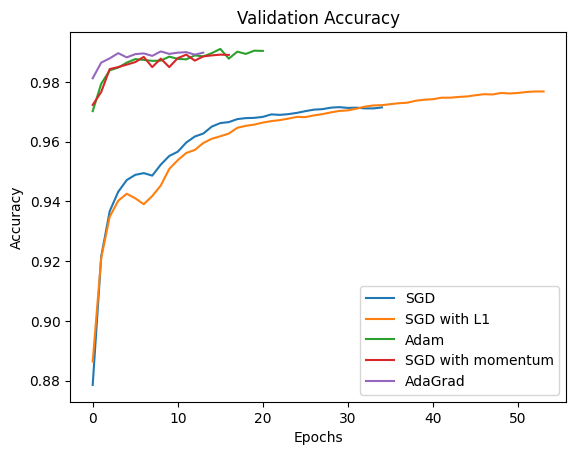

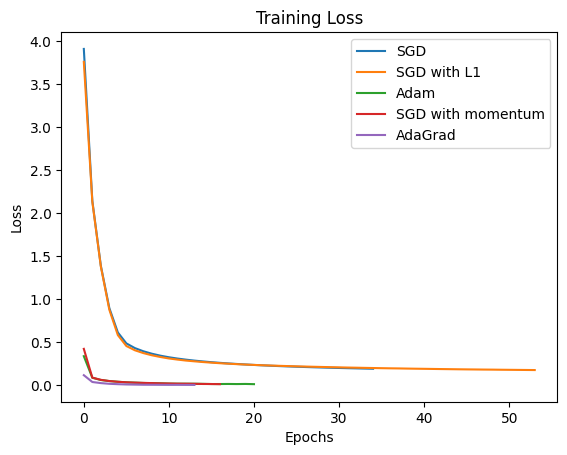

In [55]:

epoch_list = [i for i in range(len(histor_valid))]
plt.plot(epoch_list, histor_valid, label = 'SGD')
epoch_list = [i for i in range(len(histor_valid1))]
plt.plot(epoch_list, histor_valid1, label = 'SGD with L1')
epoch_list = [i for i in range(len(histor_valid2))]
plt.plot(epoch_list, histor_valid2, label = 'Adam')
epoch_list = [i for i in range(len(histor_valid3))]
plt.plot(epoch_list, histor_valid3, label = 'SGD with momentum')
epoch_list = [i for i in range(len(histor_valid4))]
plt.plot(epoch_list, histor_valid4, label = 'AdaGrad')
plt.legend()
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
epoch_list = [i for i in range(len(history_train))]
plt.plot(epoch_list, history_train, label = 'SGD')
epoch_list = [i for i in range(len(history_train1))]
plt.plot(epoch_list, history_train1, label = 'SGD with L1')
epoch_list = [i for i in range(len(history_train2))]
plt.plot(epoch_list, history_train2, label = 'Adam')
epoch_list = [i for i in range(len(history_train3))]
plt.plot(epoch_list, history_train3, label = 'SGD with momentum')
epoch_list = [i for i in range(len(history_train4))]
plt.plot(epoch_list, history_train4, label = 'AdaGrad')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [66]:

# build your CNN 
class CNN_REG(nn.Module):
    def __init__(self, dropout = 0.4, number_of_nodes=200):
        super(CNN_REG, self).__init__()
        '''Step -- Fill in the architecture'''
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
            nn.Flatten(),
            nn.BatchNorm1d(32 * 7 * 7),
        )    
        # fully connected layer, output 10 classes
        self.out = nn.Sequential(
                nn.Linear(32 * 7 * 7, number_of_nodes),
                nn.ReLU(),                      
                nn.BatchNorm1d(number_of_nodes),
                nn.Dropout(dropout),
                nn.Linear(number_of_nodes, 10),
                nn.Softmax(dim=1)
        )

    def forward(self, x):
        '''Step -- Fill in the Forward propagation function'''
        x = self.conv1(x)
        x = self.conv2(x)        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output

cnn_l26 = RegularizedNet(module = CNN_REG, criterion=torch.nn.NLLLoss, max_epochs = 100, 
                        callbacks=[('estopper', EarlyStopping(patience=5, threshold=0.01, monitor='valid_acc', lower_is_better=False, threshold_mode='abs'))],
                        optimizer = torch.optim.Adagrad, lr = 0.03, lambda1 = 0,  module__dropout = .3,
                        optimizer__weight_decay = 1e-4,
                        iterator_train__num_workers = 2,
                        iterator_train__pin_memory = True,
                        iterator_valid__num_workers = 2,
                        iterator_valid__pin_memory = True,
)


params = {'lr': [ .02, .03, .04]}
gs =  GridSearchCV(cnn_l26, params, refit = True, cv = 3, scoring = 'accuracy', n_jobs=1)
gs.fit(X_train, y_train)
cnn_126 = gs.best_estimator_ # This will give you the best estimator with the best parameters
cnn_l26.set_params(max_epochs = 100, 
                    callbacks=[('estopper', EarlyStopping(patience=5, threshold=0.0001, monitor='valid_acc', lower_is_better=False, threshold_mode='abs'))],
)
cnn_l26.fit(X_train, y_train)
y_pred = cnn_l26.predict(X_test)



  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.1422       0.9796        0.0646  6.3540
      2        0.0441       0.9882        0.0411  6.1393
      3        0.0255       0.9881        0.0361  5.9244
      4        0.0151       0.9891        0.0366  6.2656
      5        0.0100       0.9896        0.0336  6.1864
      6        0.0073       0.9899        0.0349  6.5183
      7        0.0046       0.9896        0.0334  6.9479
      8        0.0039       0.9896        0.0343  7.0097
      9        0.0031       0.9901        0.0326  6.4355
     10        0.0024       0.9900        0.0329  5.9762
Stopping since valid_acc has not improved in the last 5 epochs.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.1437       0.9811        0.0633  6.1499
      2        0.0408       0.9854        0.0473  6.0324
      3        0.0221   

In [67]:

print(accuracy_score(y_test, y_pred))
histor_valid5 = cnn_l26.history[:, 'valid_acc']
history_train5 = cnn_l26.history[:, 'train_loss']

0.9914
